# Dataset Explore

In [1]:
import contextily as cx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import torch

## Load Graph Data

In [2]:
distance_df = pd.read_csv('../datasets/PEMS-BAY/distances.csv', names=['sensor_src','sensor_dst','distance'])
sensors_df = pd.read_csv('../datasets/PEMS-BAY/sensor_locations.csv', names=['sensor_id', 'latitude', 'longitude'])

In [3]:
sensors_df.head()

,sensor_id,latitude,longitude
0,400001,37.364085,-121.901149
1,400017,37.253303,-121.945440
2,400030,37.359087,-121.906538
3,400040,37.294949,-121.873109
4,400045,37.363402,-121.902233


We convert the sensor location data to a `geopandas.GeoDataFrame` so we can visualize their positions.

In [4]:
sensors_gdf = geopandas.GeoDataFrame(
    sensors_df, 
    geometry=geopandas.points_from_xy(sensors_df.longitude, sensors_df.latitude, crs="EPSG:4326")
)

In [5]:
sensors_gdf.head()

,sensor_id,latitude,longitude,geometry
0,400001,37.364085,-121.901149,POINT (-121.90115 37.36409)
1,400017,37.253303,-121.945440,POINT (-121.94544 37.25330)
2,400030,37.359087,-121.906538,POINT (-121.90654 37.35909)
3,400040,37.294949,-121.873109,POINT (-121.87311 37.29495)
4,400045,37.363402,-121.902233,POINT (-121.90223 37.36340)


Check the format of the coordinates inferred by `geopandas`.

In [6]:
sensors_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Visualize Sensor Locations

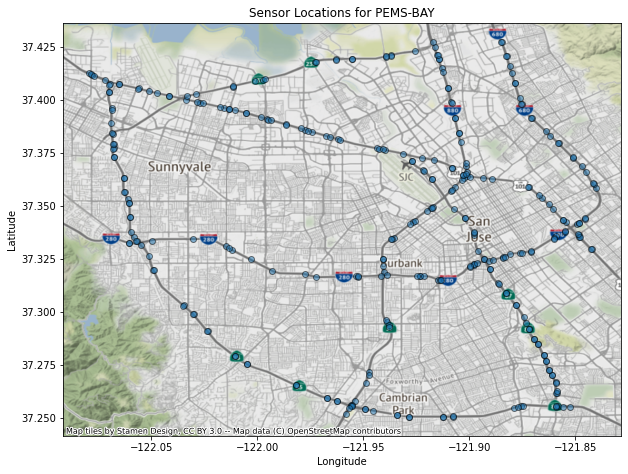

In [7]:
ax = sensors_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, zoom=12, crs=sensors_gdf.crs)
ax.set_title("Sensor Locations for PEMS-BAY")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


## Create Adjacency Matrix from Sensor Positions

Start by isolating the set of unique sensor IDs.

In [8]:
sensor_ids = sensors_df.sensor_id.unique()
sensor_ids.sort()

In [9]:
distance_df.head()

,sensor_src,sensor_dst,distance
0,400001,400001,0.0
1,400017,400017,0.0
2,400030,400030,0.0
3,400030,400045,5108.4
4,400030,400065,7401.1


Finding $V$ sensors, we construct a $V \times V$ adjacency matrix that associates sensors based on their inverse normalized distance.

In [10]:
v = sensor_ids.shape[0]
dists = np.full((v, v), np.inf)
sid_to_idx = {sid: i for i, sid in enumerate(sensor_ids)}
for src, dst, dist in distance_df.values:
    if src in sid_to_idx and dst in sid_to_idx:
        dists[sid_to_idx[src], sid_to_idx[dst]] = dist
stddev = dists[~np.isinf(dists)].std()
adj = np.exp(-(dists/stddev) ** 2)
adj[adj < 0.1] = 0

In [11]:
adj[2,4], adj[4,2]

(0.1365527590662781, 0.6148080634928663)

In [12]:
# Sparsify and Symmetrize
adj = coo_matrix(adj)
adj = (adj + adj.T)/2

In [13]:
adj[2,4], adj[4,2]

(0.3756804112795722, 0.3756804112795722)

In [14]:
adj.max(), adj.min(), (adj == 1).sum()

(1.0, 0.0, 325)

The `pytorch-geometric` library requires a list of edge endpoints and edge weights.

In [15]:
edge_idx = []
edge_wt = []
for i in range(v):
    for j in range(v):
        if adj[i,j] > 0:
            edge_idx.append((i,j))
            edge_wt.append(adj[i,j])
edge_idx = torch.tensor(edge_idx).t().contiguous()
edge_wt = torch.tensor(edge_wt)

In [16]:
edge_idx[:,:10], edge_wt[:10]

(tensor([[ 0,  1,  2,  2,  2,  2,  2,  2,  2,  2],
         [ 0,  1,  2,  4, 19, 26, 41, 68, 72, 82]]),
 tensor([1.0000, 1.0000, 1.0000, 0.3757, 0.3980, 0.1272, 0.3132, 0.4915, 0.3964,
         0.1071], dtype=torch.float64))

## Load the Traffic Data Collected by the Sensors

In [71]:
traffic_df = pd.read_hdf('../datasets/PEMS-BAY/traffic.h5')

In [72]:
traffic_df.head()

sensor_id,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
2017-01-01 00:00:00,71.4,67.8,70.5,67.4,68.8,66.6,66.8,68.0,66.8,69.0,...,68.8,67.9,68.8,68.0,69.2,68.9,70.4,68.8,71.1,68.0
2017-01-01 00:05:00,71.6,67.5,70.6,67.5,68.7,66.6,66.8,67.8,66.5,68.2,...,68.4,67.3,68.4,67.6,70.4,68.8,70.1,68.4,70.8,67.4
2017-01-01 00:10:00,71.6,67.6,70.2,67.4,68.7,66.1,66.8,67.8,66.2,67.8,...,68.4,67.4,68.4,67.5,70.2,68.3,69.8,68.4,70.5,67.9
2017-01-01 00:15:00,71.1,67.5,70.3,68.0,68.5,66.7,66.6,67.7,65.9,67.8,...,68.5,67.5,68.5,67.5,70.4,68.7,70.2,68.4,70.8,67.6
2017-01-01 00:20:00,71.7,67.8,70.2,68.1,68.4,66.9,66.1,67.7,66.1,67.8,...,68.5,67.7,68.5,67.4,69.6,69.1,70.0,68.4,71.0,67.9


In [73]:
traffic_df.values.shape

(52116, 325)

## Split the Traffic Data into Windows for Training

In [74]:
TRAIN_SIZE = 0.70
VAL_SIZE   = 0.15
TEST_SIZE  = 0.15

In [ ]:
traffic_df = traffic_df.reset_index().drop(columns=['index'])
data = traffic_df.values.astype(float)

In [75]:
train_end = int(len(data) * TRAIN_SIZE)
val_end = int(train_end + len(data) * VAL_SIZE)
train_end, val_end

In [85]:
traffic_df[:train_end].to_hdf("train.h5", key="train_data", index=False)
train_data = pd.read_hdf("train.h5").values

<ipython-input-85-6767002b10e5>:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->axis0] [items->None]

  traffic_df[:train_end].to_hdf("train.h5", key="train_data", index=False)
<ipython-input-85-6767002b10e5>:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->block0_items] [items->None]

  traffic_df[:train_end].to_hdf("train.h5", key="train_data", index=False)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/io/pytables.py:3007: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  index = factory(


In [ ]:
def window(X_raw, window_size, n_pred):
    m,n = X_raw.shape
    n_windows = m - window_size - n_pred
    X = np.zeros((n_windows, window_size, n))
    y = np.zeros((n_windows, n))
    for i in range(n_windows):
        start, end = i, i + window_size
        X[i,:] = X_raw[start:end].reshape(1, window_size, n)
        y[i] = X_raw[end + n_pred - 1]
    return X,y

In [ ]:
Xtr = data[:train_end]
Xva = data[train_end:val_end]
Xte = data[val_end:]

In [ ]:
Xtr,ytr = window(Xtr, 12, 9)
Xva,yva = window(Xva, 12, 9)
Xte,yte = window(Xte, 12, 9)
print(Xtr.shape, Xva.shape, Xte.shape)